In [33]:
import numpy as np
from sklearn.datasets import fetch_openml  
import matplotlib.pyplot as plt


In [34]:
def dataset(loader_fn, train_num, test_num):
    data_x, data_y = loader_fn
    
    classes = np.unique(data_y)
    
    train_x_list = []
    train_y_list = []
    test_x_list = []
    test_y_list = []
    
    for cls in classes:
        cls_indices = np.where(data_y == cls)[0]
        cls_indices = np.random.permutation(cls_indices)
        
        X_cls = data_x[cls_indices]
        Y_cls = data_y[cls_indices]
        
        train_x_list.append(X_cls[:train_num])
        train_y_list.append(Y_cls[:train_num])
        
        test_x_list.append(X_cls[train_num:train_num + test_num])
        test_y_list.append(Y_cls[train_num:train_num + test_num])
        
    X_train = np.concatenate(train_x_list)
    y_train = np.concatenate(train_y_list)
    X_test = np.concatenate(test_x_list)
    y_test = np.concatenate(test_y_list)
    
    train_perm = np.random.permutation(len(X_train))
    X_train = X_train[train_perm]
    y_train = y_train[train_perm]
    
    test_perm = np.random.permutation(len(X_test))
    X_test = X_test[test_perm]
    y_test = y_test[test_perm]
    
    return X_train, y_train, X_test, y_test

In [35]:
data = fetch_openml("mnist_784")

In [36]:
# Load and preprocess MNIST dataset
# Normalize pixel values to range 0-1 by dividing by 255.0 (grayscale images originally 0-255)
# Convert labels to integer type using astype('int16') to ensure numeric operations work correctly 

X_train, y_train, X_test, y_test = dataset(
    (
        np.asarray(data["data"].values) / 255.0,                 # Normalize input images
        np.asarray(data["target"].values.astype('int16'))        # Convert labels to integers
    ),
    train_num=3000,
    test_num=100
)


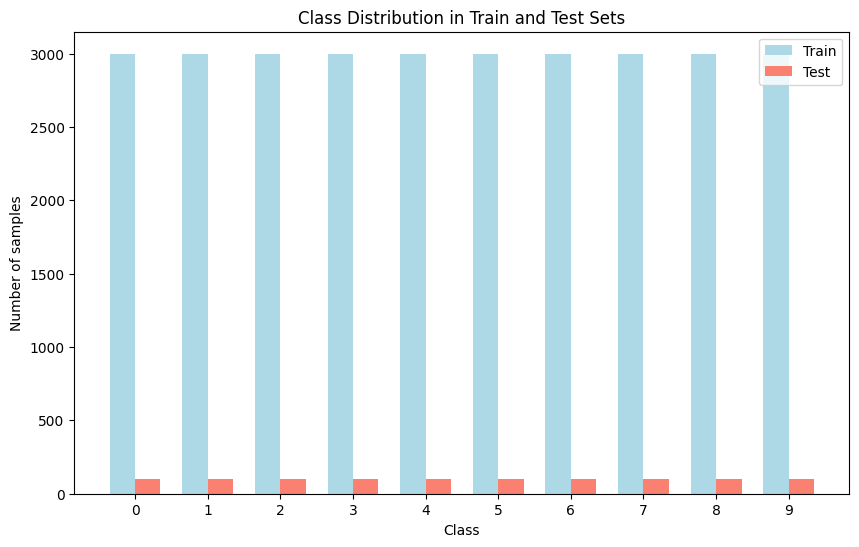

In [37]:
def plot_class_distribution(y_train, y_test, num_classes):
    # Count samples per class
    train_counts = [np.sum(y_train == i) for i in range(num_classes)]
    test_counts = [np.sum(y_test == i) for i in range(num_classes)]
    
    # Set up the bar positions
    x = np.arange(num_classes)
    width = 0.35  # width of bars
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(x - width/2, train_counts, width, label='Train', color='lightblue')
    ax.bar(x + width/2, test_counts, width, label='Test', color='salmon') 

    
    # Labels and title
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of samples')
    ax.set_title('Class Distribution in Train and Test Sets')
    ax.set_xticks(x)
    ax.set_xticklabels([str(i) for i in range(num_classes)])
    ax.legend()
    
    plt.show()

plot_class_distribution(y_train, y_test, num_classes = 10)


In [38]:
class Parameter:
    def __init__(self, data):
        self.data = data
        self.grad = np.zeros_like(data)
        
class Module:
    def __init__(self):
        self.params = {}
        self.layer_dict = {}     # Add

    def forward(self, *args, **kwargs):
        raise NotImplementedError

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def __setattr__(self, name, value):
        if isinstance(value, Parameter):
            self.params[name] = value

        if isinstance(value, Module):
            self.layer_dict[name] = value
        super().__setattr__(name, value)

    def parameters(self):
        params = list(self.params.values())
        for attr in self.__dict__.values():
            if isinstance(attr, Module):
                params.extend(attr.parameters())
        return params

    # Add
    def backward(self, grad_output):
        for layer in reversed(list(self.layer_dict.values())):
            grad_output = layer.backward(grad_output)
        return grad_output

In [39]:
class Linear(Module):
    def __init__(self, *args):
        super().__init__()
        # Normal mode: user specifies input and output size
        if len(args) == 2:  # example: Linear(128, 32)
            in_features, out_features = args
            self.deferred_init = False
            self.initialize_params(in_features, out_features)

        # Deferred initialization: Linear(32)
        elif len(args) == 1:
            (out_features,) = args
            self.deferred_init = True
            self.out_features = out_features
            self.W = None
            self.b = None
        else:
            raise ValueError("Linear expects 1 or 2 arguments")


    def initialize_params(self, in_features, out_features):
        # simple 
        # self.W = Parameter(np.random.randn(in_features, out_features) * 0.01)   # (in_features, out_features, )

        # Kaiming He normal initialization
        std = np.sqrt(2.0 / in_features)                    
        self.W = Parameter(np.random.randn(in_features, out_features) * std)  # (in_features, out_features, )
        
        self.b = Parameter(np.zeros(out_features)) # (output_features,)


    def forward(self, x):
        # Deferred initialization
        if self.deferred_init and self.W is None:
            in_features = x.shape[-1]
            self.initialize_params(in_features, self.out_features)
            self.deferred_init = False

        self.x = x
        # x: (batch, in_features) 
        return x @ self.W.data + self.b.data    # (batch, out_features)
    
    def backward(self, grad_output):
        self.W.grad += self.x.T @ grad_output      # (in, batch) @ (batch, out) → (in, out)
        self.b.grad += grad_output.sum(axis=0)
        return grad_output @ self.W.data.T          # (batch, out) @ (out, in) → (batch, in)

In [40]:
class ReLU(Module):
    def forward(self, x):
        self.mask = x > 0
        return x * self.mask

    def backward(self, grad_input):
        return grad_input * self.mask

In [41]:
class MSE:
    def forward(self, y_pred, y_true):
        self.y_pred = y_pred  # Store predictions for backward pass

        # Convert 1D class labels to one-hot if needed
        if y_true.ndim == 1:
            num_classes = y_pred.shape[1]
            self.y_true = np.eye(num_classes)[y_true]
        else:
            self.y_true = y_true  # Already in proper shape

        # Match dtype with predictions
        self.y_true = self.y_true.astype(y_pred.dtype)

        # Average of squared differences
        loss = np.mean((y_pred - self.y_true) ** 2)
        return loss
    
    def backward(self): # dL/dY_pred
        return 2 * (self.y_pred - self.y_true) / self.y_true.shape[0]

In [42]:
class CrossEntropy:
    def forward(self, y_pred, y_true):
        self.y_pred = y_pred # Store predictions for backward pass

        # If labels are 1D (class indices), convert them to one-hot encoding
        if y_true.ndim == 1:
            num_classes = y_pred.shape[1]  # Number of output classes
            self.y_true = np.eye(num_classes)[y_true]  # One-hot encode
        else:
            self.y_true = y_true  # Already one-hot encoded

        # Match dtype with predictions
        self.y_true = self.y_true.astype(y_pred.dtype)

        # Clip predictions to avoid log(0) which can cause numerical issues
        y_pred_clipped = np.clip(y_pred, 1e-12, 1.0)

        # Compute cross-entropy loss:
        #   - sum over classes for each sample
        #   - then average over all samples
        loss = -np.mean(np.sum(self.y_true * np.log(y_pred_clipped), axis=1))
        return loss
    
    def backward(self):
        N = self.y_pred.shape[0]  # batch size
        # Gradient: (y_pred - y_true) / N
        grad = (self.y_pred - self.y_true) / N
        return grad

In [43]:
class SGD:
    def __init__(self, _module, lr=0.01):
        # Check if the input _module is an instance of the Module class
        # (e.g., Linear, Activation layers)
        if isinstance(_module, Module):  # If it's a Module, get all the parameters (weights and biases)
            self._module = _module.parameters()
        else:
            # If it's already a list of parameters, assign it directly
            self._module = _module
        self.lr = lr  # Set learning rate (default 0.01)

    def step(self):
        # Loop through all weights and biases of the model
        for param in self._module:
            # Update each weights and biases using SGD formula
            param.data -= self.lr * param.grad

    def zero_grad(self):
        for param in self._module:
            param.grad[...] = 0  # reset their gradients to zero to prevent accumulation from previous steps

In [44]:
def accuracy(logits, targets):
    preds = np.argmax(logits, axis=1)
    return np.mean(preds == targets)

In [45]:
class Sequential(Module):
    def __init__(self, layers):
        super().__init__()
        self.layer_dict = {}
        for i, layer in enumerate(layers):
            name = "layer" + str(i).zfill(5)
            self.layer_dict[name] = layer


    def forward(self, x):
        # Apply each layer in order
        for i in sorted(self.layer_dict.keys()):
            x = self.layer_dict[i](x)
        return x

    def backward(self, grad_output):
        # Backpropagate through each layer in reverse order
        for i in reversed(sorted(self.layer_dict.keys())):
            grad_output = self.layer_dict[i].backward(grad_output)
        return grad_output

    def parameters(self):
        # Collect parameters from all layers
        params = []
        for layer in self.layer_dict.values():
            if hasattr(layer, 'parameters'):
                params.extend(layer.parameters())
        return params

In [46]:
model_seq = Sequential([
    Linear(784, 128),
    ReLU(),
    Linear(32),
    ReLU(),
    Linear(10),
])

In [47]:
class MyModel(Module):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(784, 128)
        self.relu1 = ReLU()
        self.fc2 = Linear(128, 32)
        self.relu2 = ReLU()
        self.fc3 = Linear(32, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x
    
model_custom = MyModel()

In [48]:
# loss_fn = MSE()
loss_fn = CrossEntropy()

epochs = 30
batch_size = 64
initial_lr = 0.01

model = model_seq
# model = model_custom 

optimizer = SGD(model.parameters(), lr=initial_lr)

for epoch in range(epochs):
    for i in range(0, X_train.shape[0], batch_size):
        x_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        logits = model.forward(x_batch)
        loss = loss_fn.forward(logits, y_batch)
        grad_output = loss_fn.backward()
        model.backward(grad_output)
        optimizer.step()
        optimizer.zero_grad()

    logits_train = model.forward(X_train)
    train_loss = loss_fn.forward(logits_train, y_train)
    train_acc = accuracy(logits_train, y_train)

    logits_test = model.forward(X_test)
    test_loss = loss_fn.forward(logits_test, y_test)
    test_acc = accuracy(logits_test, y_test)

    print(f"Epoch {epoch+1} Summary: "
          f"Train Acc={train_acc:.4f}, Train Loss={train_loss:.4f}, "
          f"Test Acc={test_acc:.4f}, Test Loss={test_loss:.4f}")


Epoch 1 Summary: Train Acc=0.6171, Train Loss=2.0335, Test Acc=0.6130, Test Loss=2.0902
Epoch 2 Summary: Train Acc=0.7534, Train Loss=1.3832, Test Acc=0.7440, Test Loss=1.6010
Epoch 3 Summary: Train Acc=0.8113, Train Loss=1.1088, Test Acc=0.7970, Test Loss=1.3291
Epoch 4 Summary: Train Acc=0.8396, Train Loss=0.9648, Test Acc=0.8270, Test Loss=1.1868
Epoch 5 Summary: Train Acc=0.8593, Train Loss=0.8714, Test Acc=0.8420, Test Loss=1.0780
Epoch 6 Summary: Train Acc=0.8723, Train Loss=0.8082, Test Acc=0.8540, Test Loss=1.0120
Epoch 7 Summary: Train Acc=0.8811, Train Loss=0.7592, Test Acc=0.8610, Test Loss=0.9564
Epoch 8 Summary: Train Acc=0.8879, Train Loss=0.7208, Test Acc=0.8680, Test Loss=0.9048
Epoch 9 Summary: Train Acc=0.8942, Train Loss=0.6930, Test Acc=0.8720, Test Loss=0.8596
Epoch 10 Summary: Train Acc=0.8984, Train Loss=0.6644, Test Acc=0.8750, Test Loss=0.8186
Epoch 11 Summary: Train Acc=0.9020, Train Loss=0.6402, Test Acc=0.8800, Test Loss=0.8011
Epoch 12 Summary: Train Acc=0.